<a href="https://colab.research.google.com/github/rohmish2/FinalTermProject/blob/main/CacheEvictionUsingDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
DRL-CACHE: Complete Evaluation

Workloads: Zipf, Temporal, Loop, Trap, Phase-Change, Size-Aware

Zipf           :  3957 objects,  30000 requests, conc=0.81
Temporal       :   889 objects,  30000 requests, conc=0.96
Loop           :   150 objects,  30000 requests, conc=0.22
Trap           :   897 objects,  30000 requests, conc=0.74
Phase-Change   :  1000 objects,  30000 requests, conc=0.60
Size-Aware     :   648 objects,  30000 requests, conc=0.79

Zipf Cache Config:
  Total objects: 3957
  Working set: 196.04 MB
  Cache size: 29.41 MB
  Cache ratio: 15.0%
Training DQN...
Evaluating policies...
  LRU     : HR=0.6914, BHR=0.6879
  LFU     : HR=0.7047, BHR=0.7020
  FIFO    : HR=0.6638, BHR=0.6604
  Random  : HR=0.6682, BHR=0.6669
  DQN     : HR=0.6922, BHR=0.6884

Temporal Cache Config:
  Total objects: 889
  Working set: 223.29 MB
  Cache size: 33.49 MB
  Cache ratio: 15.0%
Training DQN...
Evaluating policies...
  LRU     : HR=0.9421, BHR=0.7240
  LFU     : HR=0.9434, 

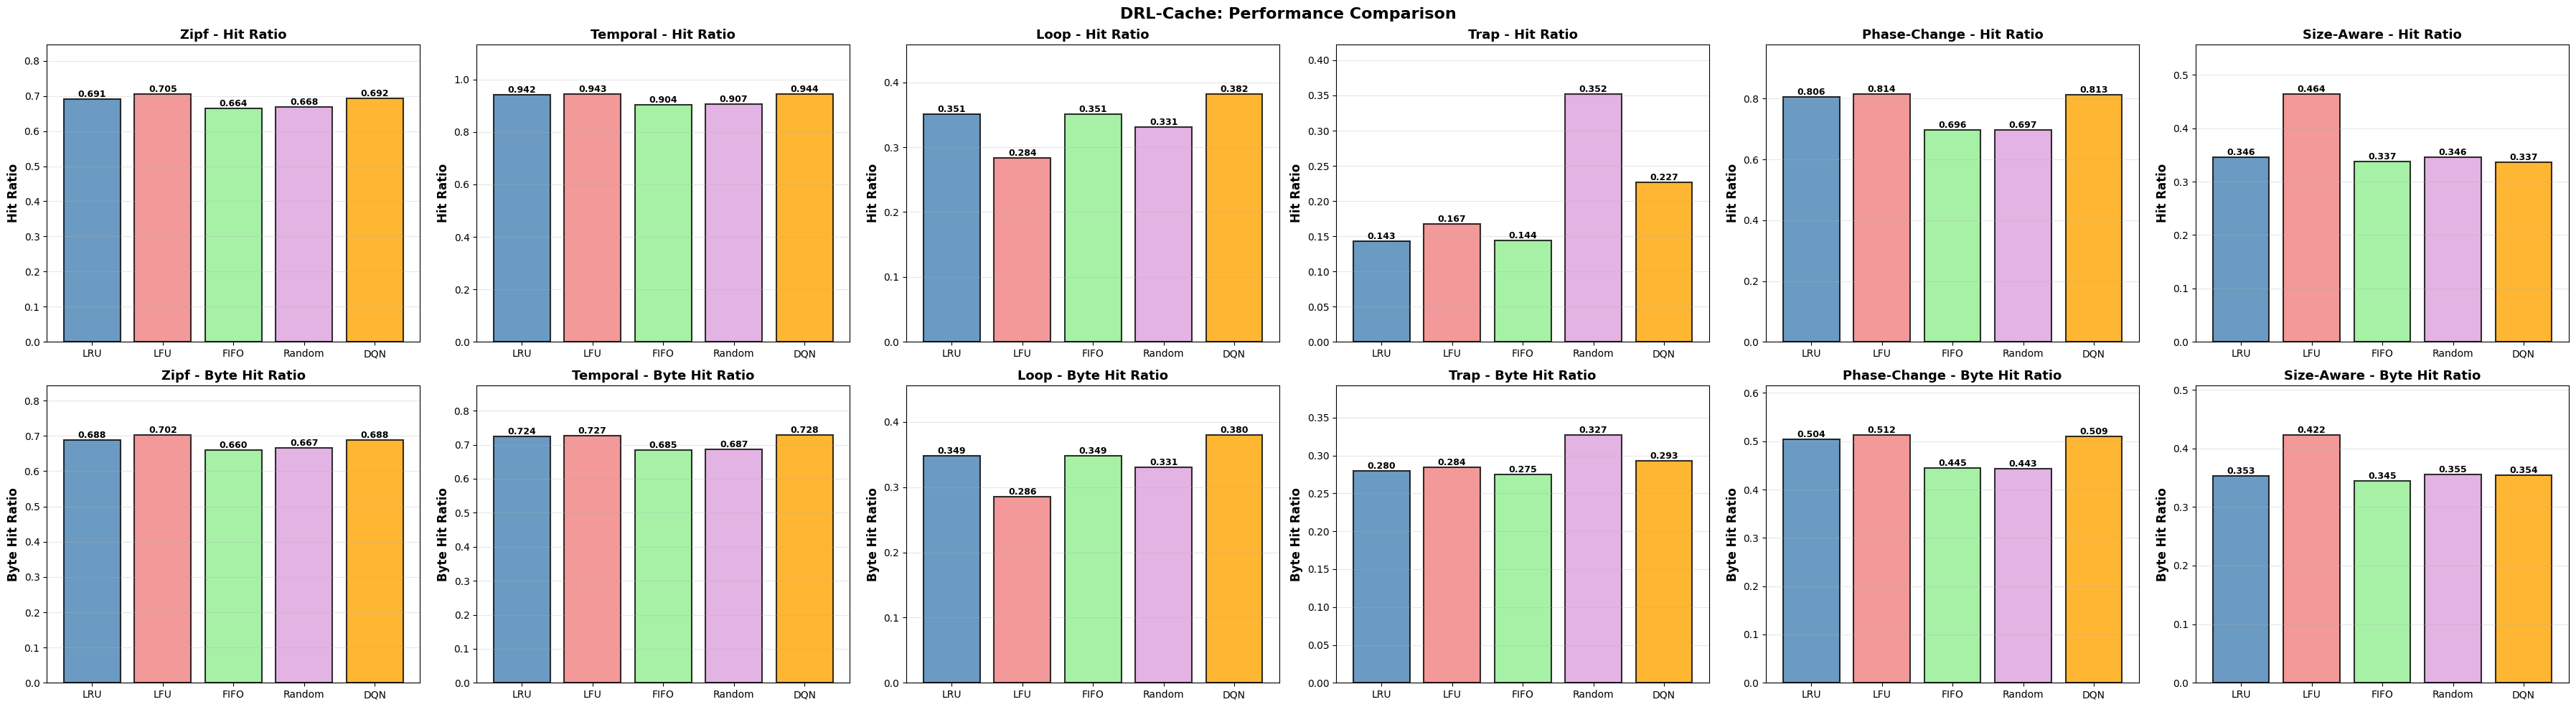

In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, defaultdict
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

class DQN(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim // 2, 1)

        for layer in [self.fc1, self.fc2, self.fc3, self.fc4]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)



# CACHE OBJECT

class CacheObject:
    def __init__(self, obj_id, size, timestamp):
        self.obj_id = obj_id
        self.size = size
        self.insert_time = timestamp
        self.last_access = timestamp
        self.hit_count = 0
        self.access_history = [timestamp]


# METRICS TRACKER

class MetricsTracker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.hits = 0
        self.misses = 0
        self.byte_hits = 0
        self.byte_misses = 0
        self.eviction_ages = []
        self.eviction_sizes = []

    def record_hit(self, size):
        self.hits += 1
        self.byte_hits += size

    def record_miss(self, size):
        self.misses += 1
        self.byte_misses += size

    def record_eviction(self, obj, current_time):
        age = current_time - obj.insert_time
        self.eviction_ages.append(age)
        self.eviction_sizes.append(obj.size)

    def get_metrics(self):
        total = self.hits + self.misses
        total_bytes = self.byte_hits + self.byte_misses

        return {
            'hit_ratio': self.hits / total if total > 0 else 0.0,
            'miss_ratio': self.misses / total if total > 0 else 0.0,
            'byte_hit_ratio': self.byte_hits / total_bytes if total_bytes > 0 else 0.0,
            'avg_eviction_age': np.mean(self.eviction_ages) if self.eviction_ages else 0,
            'avg_eviction_size': np.mean(self.eviction_sizes) if self.eviction_sizes else 0,
            'total_requests': total,
            'total_hits': self.hits,
            'total_misses': self.misses
        }




class BaseCache:
    def __init__(self, capacity):
        self.capacity = capacity
        self.cache = {}
        self.current_size = 0
        self.time = 0
        self.metrics = MetricsTracker()

    def access(self, obj_id, size):
        self.time += 1

        # Hit
        if obj_id in self.cache:
            obj = self.cache[obj_id]
            obj.last_access = self.time
            obj.hit_count += 1
            obj.access_history.append(self.time)
            self.metrics.record_hit(size)
            return True

        self.metrics.record_miss(size)

        # Eviction
        while self.current_size + size > self.capacity and self.cache:
            victim = self.select_victim()
            if victim:
                self.evict(victim)
            else:
                break

        # Insert
        if self.current_size + size <= self.capacity:
            self.cache[obj_id] = CacheObject(obj_id, size, self.time)
            self.current_size += size

        return False

    def select_victim(self):
        raise NotImplementedError

    def evict(self, obj_id):
        if obj_id in self.cache:
            obj = self.cache[obj_id]
            self.metrics.record_eviction(obj, self.time)
            self.current_size -= obj.size
            del self.cache[obj_id]

    def reset(self):
        self.cache.clear()
        self.current_size = 0
        self.time = 0
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.get_metrics()



class LRUCache(BaseCache):
    def select_victim(self):
        if not self.cache:
            return None
        return min(self.cache.keys(), key=lambda k: self.cache[k].last_access)


class LFUCache(BaseCache):
    def select_victim(self):
        if not self.cache:
            return None
        return min(self.cache.keys(), key=lambda k: self.cache[k].hit_count)


class FIFOCache(BaseCache):
    def select_victim(self):
        if not self.cache:
            return None
        return min(self.cache.keys(), key=lambda k: self.cache[k].insert_time)


class RandomCache(BaseCache):
    def select_victim(self):
        if not self.cache:
            return None
        return random.choice(list(self.cache.keys()))



class DQNCache(BaseCache):
    def __init__(self, capacity, device=DEVICE, num_candidates=10):
        super().__init__(capacity)
        self.device = device
        self.num_candidates = num_candidates

        # Networks
        self.policy_net = DQN(input_dim=6, hidden_dim=128).to(device)
        self.target_net = DQN(input_dim=6, hidden_dim=128).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Training
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.0003)
        self.buffer = deque(maxlen=20000)
        self.epsilon = 0.1
        self.gamma = 0.99
        self.training = False

        # Simple tracking
        self.last_state = None
        self.last_action = None
        self.last_candidates = None

    def extract_features(self, obj):
        age = max(1, self.time - obj.insert_time)
        inter_arrival = max(1, self.time - obj.last_access)

        features = np.array([
            np.log1p(age) / 10.0,
            np.log1p(obj.size) / 20.0,
            np.log1p(obj.hit_count) / 5.0,
            np.log1p(inter_arrival) / 10.0,
            self.current_size / self.capacity,
            len(self.cache) / max(1, self.capacity / 1000)
        ], dtype=np.float32)

        features = np.clip(features, 0, 10)
        features = np.nan_to_num(features, nan=0.0, posinf=1.0, neginf=0.0)

        return features

    def get_candidates(self):
        if not self.cache:
            return []

        cache_ids = list(self.cache.keys())
        k = min(self.num_candidates, len(cache_ids))

        # LRU candidates
        sorted_ids = sorted(cache_ids, key=lambda k: self.cache[k].last_access)
        return sorted_ids[:k]

    def select_victim(self):
        candidates = self.get_candidates()
        if not candidates:
            return None

        # Extract features
        features = [self.extract_features(self.cache[oid]) for oid in candidates]

        # Epsilon-greedy selection
        if self.training and random.random() < self.epsilon:
            action_idx = random.randint(0, len(features) - 1)
        else:
            # Greedy
            self.policy_net.eval()
            best_idx = 0
            best_score = -float('inf')

            with torch.no_grad():
                for idx, feat in enumerate(features):
                    feat_tensor = torch.from_numpy(feat).float().unsqueeze(0).to(self.device)
                    score = self.policy_net(feat_tensor).item()

                    if np.isfinite(score) and score > best_score:
                        best_score = score
                        best_idx = idx

            action_idx = best_idx

        # Store for experience replay
        if self.training:
            self.last_state = features[action_idx]
            self.last_action = action_idx
            self.last_candidates = candidates

        return candidates[action_idx]

    def access(self, obj_id, size):
        """Override to track rewards"""
        # Store previous state for experience
        prev_state = self.last_state
        prev_action = self.last_action

        # Execute access
        hit = super().access(obj_id, size)

        # Store experience if training
        if self.training and prev_state is not None:
            # Simple reward: +1 for hit, -0.1 for miss
            reward = 1.0 if hit else -0.1

            # Get next state (current victim candidate if eviction will happen)
            next_state = prev_state  # Simplified
            done = False

            self.buffer.append({
                'state': prev_state,
                'action': prev_action,
                'reward': reward,
                'next_state': next_state,
                'done': done
            })

        return hit

    def train_step(self, batch_size=128):
        if len(self.buffer) < batch_size:
            return None

        try:
            batch = random.sample(self.buffer, batch_size)

            # Prepare batch
            states = torch.from_numpy(np.array([exp['state'] for exp in batch], dtype=np.float32)).to(self.device)
            rewards = torch.tensor([exp['reward'] for exp in batch], dtype=torch.float32).to(self.device)
            next_states = torch.from_numpy(np.array([exp['next_state'] for exp in batch], dtype=np.float32)).to(self.device)
            dones = torch.tensor([exp['done'] for exp in batch], dtype=torch.float32).to(self.device)

            # Current Q-values
            self.policy_net.train()
            current_q = self.policy_net(states).squeeze()

            # Target Q-values
            with torch.no_grad():
                next_q = self.target_net(next_states).squeeze()
                target_q = rewards + self.gamma * next_q * (1 - dones)

            # Loss
            loss = F.smooth_l1_loss(current_q, target_q)

            if not torch.isfinite(loss):
                return None

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
            self.optimizer.step()

            return loss.item()

        except Exception as e:
            return None

    def update_target(self):
        """Soft update of target network"""
        tau = 0.005
        for target_param, policy_param in zip(self.target_net.parameters(),
                                               self.policy_net.parameters()):
            target_param.data.copy_(
                tau * policy_param.data + (1.0 - tau) * target_param.data
            )


def generate_zipf_workload(num_requests=30000, alpha=1.2, num_objects=5000):
    np.random.seed(42)
    requests = []

    for i in range(num_requests):
        obj_id = int(np.random.zipf(alpha)) % num_objects
        size = np.random.randint(1024, 102400)
        requests.append((i, f"zipf_{obj_id}", size))

    return requests


def generate_temporal_locality(num_requests=30000):
    np.random.seed(42)
    requests = []

    hot_objects = [f"hot_{i}" for i in range(20)]
    warm_objects = [f"warm_{i}" for i in range(100)]
    cold_objects = [f"cold_{i}" for i in range(1000)]

    for i in range(num_requests):
        rand = np.random.random()

        if rand < 0.7:
            obj_id = np.random.choice(hot_objects)
            size = np.random.randint(10240, 51200)
        elif rand < 0.95:
            obj_id = np.random.choice(warm_objects)
            size = np.random.randint(20480, 102400)
        else:
            obj_id = np.random.choice(cold_objects)
            size = np.random.randint(102400, 512000)

        requests.append((i, obj_id, size))

    return requests


def generate_loop_workload(num_requests=30000, loop_size=100):
    np.random.seed(42)
    requests = []

    for i in range(num_requests):
        obj_id = (i % loop_size) + np.random.randint(-5, 5)
        obj_id = max(0, obj_id % loop_size)
        size = np.random.randint(4096, 40960)
        requests.append((i, f"loop_{obj_id}", size))

    return requests


def generate_trap_benchmark(num_requests=30000, cache_capacity=50000):

    requests = []
    timestamp = 0

    # Phase 1: Size Inversion (30%)
    normal_phase = int(num_requests * 0.3)
    large_popular = [f"large_pop_{i}" for i in range(20)]
    small_unpopular = [f"small_unpop_{i}" for i in range(500)]

    for i in range(normal_phase):
        if np.random.random() < 0.8:
            obj_id = np.random.choice(large_popular)
            size = np.random.randint(50000, 100000)
        else:
            obj_id = np.random.choice(small_unpopular)
            size = np.random.randint(1024, 2048)
        requests.append((timestamp, obj_id, size))
        timestamp += 1

    # Phase 2: Periodic Bursts (30%)
    burst_phase = int(num_requests * 0.3)
    baseline_objects = [f"baseline_{i}" for i in range(50)]
    burst_objects = [f"burst_{i}" for i in range(100)]

    for i in range(burst_phase):
        if (i % 500) < 100:
            obj_id = np.random.choice(burst_objects)
            size = np.random.randint(5120, 20480)
        else:
            obj_id = np.random.choice(baseline_objects)
            size = np.random.randint(4096, 10240)
        requests.append((timestamp, obj_id, size))
        timestamp += 1

    # Phase 3: Scanning Attack (20%)
    scan_phase = int(num_requests * 0.2)
    hot_objects = [f"hot_{i}" for i in range(30)]
    scan_objects = [f"scan_{i}" for i in range(200)]

    for i in range(scan_phase):
        if (i % 200) < 150:
            obj_id = scan_objects[i % len(scan_objects)]
            size = np.random.randint(4096, 6144)
        else:
            obj_id = np.random.choice(hot_objects)
            size = np.random.randint(2048, 4096)
        requests.append((timestamp, obj_id, size))
        timestamp += 1

    # Phase 4: Mixed (20%)
    mixed_phase = num_requests - len(requests)
    for i in range(mixed_phase):
        choice = np.random.choice(['size', 'burst', 'scan'], p=[0.4, 0.3, 0.3])

        if choice == 'size':
            if np.random.random() < 0.7:
                obj_id = np.random.choice(large_popular)
                size = np.random.randint(50000, 100000)
            else:
                obj_id = np.random.choice(small_unpopular)
                size = np.random.randint(1024, 2048)
        elif choice == 'burst':
            obj_id = np.random.choice(burst_objects if i % 100 < 30 else baseline_objects)
            size = np.random.randint(4096, 20480)
        else:
            obj_id = np.random.choice(scan_objects)
            size = np.random.randint(4096, 6144)

        requests.append((timestamp, obj_id, size))
        timestamp += 1

    return requests


def generate_phase_change_workload(num_requests=30000):
    requests = []
    num_phases = 3
    phase_length = num_requests // num_phases

    for phase in range(num_phases):
        hot_start = phase * 100
        hot_objects = [f"obj_{i}" for i in range(hot_start, hot_start + 100)]
        cold_objects = [f"obj_{i}" for i in range(1000) if i < hot_start or i >= hot_start + 100]

        for i in range(phase_length):
            timestamp = phase * phase_length + i
            if np.random.random() < 0.8:
                obj_id = np.random.choice(hot_objects)
                size = np.random.randint(2048, 10240)
            else:
                obj_id = np.random.choice(cold_objects)
                size = np.random.randint(10240, 51200)
            requests.append((timestamp, obj_id, size))

    return requests


def generate_size_aware_workload(num_requests=30000):
    requests = []

    tiny_hot = [f"tiny_hot_{i}" for i in range(100)]
    large_warm = [f"large_warm_{i}" for i in range(50)]
    medium_cold = [f"medium_cold_{i}" for i in range(500)]

    for i in range(num_requests):
        rand = np.random.random()
        if rand < 0.6:
            obj_id = np.random.choice(tiny_hot)
            size = np.random.randint(1024, 2048)
        elif rand < 0.9:
            obj_id = np.random.choice(large_warm)
            size = np.random.randint(51200, 102400)
        else:
            obj_id = np.random.choice(medium_cold)
            size = np.random.randint(10240, 20480)
        requests.append((i, obj_id, size))

    return requests


def train_dqn(train_data, capacity, epochs=3, device=DEVICE):
    """Train DQN cache"""
    cache = DQNCache(capacity, device=device, num_candidates=10)
    cache.training = True
    cache.epsilon = 0.5

    for epoch in range(epochs):
        cache.reset()
        losses = []

        for idx, (ts, obj_id, size) in enumerate(train_data):
            cache.access(obj_id, size)

            # Train periodically
            if len(cache.buffer) >= 128 and idx % 20 == 0:
                loss = cache.train_step(128)
                if loss is not None:
                    losses.append(loss)

            # Update target network
            if idx % 500 == 0:
                cache.update_target()

        # Decay epsilon
        cache.epsilon = max(0.01, cache.epsilon * 0.85)

        metrics = cache.get_metrics()
        avg_loss = np.mean(losses) if losses else 0

    cache.training = False
    cache.epsilon = 0.0
    return cache


def evaluate_policies(test_data, capacity, dqn_cache=None):
    """Evaluate all policies"""
    policies = {
        'LRU': LRUCache(capacity),
        'LFU': LFUCache(capacity),
        'FIFO': FIFOCache(capacity),
        'Random': RandomCache(capacity)
    }

    if dqn_cache:
        policies['DQN'] = dqn_cache

    all_metrics = {}

    for name, cache in policies.items():
        cache.reset()

        for ts, obj_id, size in test_data:
            cache.access(obj_id, size)

        metrics = cache.get_metrics()
        all_metrics[name] = metrics

    return all_metrics



def get_pressure_regimes(workload):
    """Calculate cache sizes for different pressure levels"""
    unique_objects = {}
    for ts, obj_id, size in workload:
        if obj_id not in unique_objects:
            unique_objects[obj_id] = size

    working_set = sum(unique_objects.values())

    regimes = {
        'high': max(10000, int(working_set * 0.01)),
        'medium': max(50000, int(working_set * 0.10)),
        'low': max(200000, int(working_set * 0.40))
    }

    return regimes


def analyze_workload(workload, name):
    """Analyze workload characteristics"""
    access_counts = defaultdict(int)
    for ts, obj_id, size in workload:
        access_counts[obj_id] += 1

    unique_objects = len(access_counts)
    total_requests = len(workload)

    sorted_counts = sorted(access_counts.values(), reverse=True)
    top_20_pct = int(0.20 * len(sorted_counts)) or 1
    concentration = sum(sorted_counts[:top_20_pct]) / total_requests

    return {
        'name': name,
        'unique_objects': unique_objects,
        'total_requests': total_requests,
        'concentration': concentration
    }



def visualize_results(all_results, filename='drl_cache_results.png'):
    """Visualize results"""
    n_workloads = len(all_results)
    fig, axes = plt.subplots(2, n_workloads, figsize=(6*n_workloads, 10))

    if n_workloads == 1:
        axes = axes.reshape(-1, 1)

    for idx, (workload_name, results) in enumerate(all_results.items()):
        # Hit Ratio
        ax1 = axes[0, idx]
        policies = list(results.keys())
        hit_ratios = [results[p]['hit_ratio'] for p in policies]
        colors = ['steelblue', 'lightcoral', 'lightgreen', 'plum', 'orange']

        bars1 = ax1.bar(policies, hit_ratios, color=colors[:len(policies)],
                        alpha=0.8, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Hit Ratio', fontsize=12, fontweight='bold')
        ax1.set_title(f'{workload_name} - Hit Ratio', fontweight='bold', fontsize=13)
        ax1.set_ylim(0, max(hit_ratios) * 1.2)
        ax1.grid(True, alpha=0.3, axis='y')

        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

        # Byte Hit Ratio
        ax2 = axes[1, idx]
        byte_hit_ratios = [results[p]['byte_hit_ratio'] for p in policies]

        bars2 = ax2.bar(policies, byte_hit_ratios, color=colors[:len(policies)],
                        alpha=0.8, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Byte Hit Ratio', fontsize=12, fontweight='bold')
        ax2.set_title(f'{workload_name} - Byte Hit Ratio', fontweight='bold', fontsize=13)
        ax2.set_ylim(0, max(byte_hit_ratios) * 1.2 if byte_hit_ratios else 1)
        ax2.grid(True, alpha=0.3, axis='y')

        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

    plt.suptitle('DRL-Cache: Performance Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.close

def calculate_optimal_cache_size(workload, pressure_level='medium'):
    """Calculate cache size based on workload characteristics"""
    unique_objects = {}
    access_counts = defaultdict(int)

    for ts, obj_id, size in workload:
        if obj_id not in unique_objects:
            unique_objects[obj_id] = size
        access_counts[obj_id] += 1

    # Total working set
    working_set = sum(unique_objects.values())
    num_objects = len(unique_objects)

    # Calculate hot set (80-20 rule: top 20% objects get 80% accesses)
    sorted_objects = sorted(access_counts.items(),
                           key=lambda x: x[1], reverse=True)
    hot_count = max(1, int(num_objects * 0.20))
    hot_objects_size = sum(unique_objects[obj_id]
                          for obj_id, _ in sorted_objects[:hot_count])

    # Pressure-based sizing
    pressure_factors = {
        'high': 0.05,      # 5% - aggressive eviction
        'medium': 0.15,    # 15% - balanced
        'low': 0.40        # 40% - minimal eviction
    }

    factor = pressure_factors.get(pressure_level, 0.15)

    return {
        'cache_size': int(working_set * factor),
        'working_set': working_set,
        'num_objects': num_objects,
        'hot_set_size': hot_objects_size,
        'avg_object_size': working_set / num_objects if num_objects > 0 else 0
    }
def main():
    print("="*70)
    print("DRL-CACHE: Complete Evaluation")
    print("="*70)

    # Define workloads
    workloads = {
        'Zipf': generate_zipf_workload(30000, alpha=1.2),
        'Temporal': generate_temporal_locality(30000),
        'Loop': generate_loop_workload(30000, loop_size=150),
        'Trap': generate_trap_benchmark(30000, cache_capacity=50000),
        'Phase-Change': generate_phase_change_workload(30000),
        'Size-Aware': generate_size_aware_workload(30000),
    }

    print(f"\nWorkloads: {', '.join(workloads.keys())}\n")

    # Analyze workloads
    for name, workload in workloads.items():
        stats = analyze_workload(workload, name)
        print(f"{name:15s}: {stats['unique_objects']:5d} objects, {stats['total_requests']:6d} requests, "
              f"conc={stats['concentration']:.2f}")

    all_results = {}
    capacity = 1024*1024*5  # Fixed capacity

    # Evaluate each workload
    for name, workload in workloads.items():
        cache_config = calculate_optimal_cache_size(workload, 'medium')
        capacity = cache_config['cache_size']

        print(f"\n{name} Cache Config:")
        print(f"  Total objects: {cache_config['num_objects']}")
        print(f"  Working set: {cache_config['working_set'] / (1024*1024):.2f} MB")
        print(f"  Cache size: {capacity / (1024*1024):.2f} MB")
        print(f"  Cache ratio: {capacity / cache_config['working_set'] * 100:.1f}%")

        # Split train/test
        split = int(0.7 * len(workload))
        train_data = workload[:split]
        test_data = workload[split:]

        print("Training DQN...")
        dqn_cache = train_dqn(train_data, capacity, epochs=3)

        # Evaluate
        print("Evaluating policies...")
        results = evaluate_policies(test_data, capacity, dqn_cache)
        all_results[name] = results

        # Print results
        for policy, metrics in results.items():
            print(f"  {policy:8s}: HR={metrics['hit_ratio']:.4f}, BHR={metrics['byte_hit_ratio']:.4f}")

    visualize_results(all_results)

    # Summary
    print(f"\n{'='*70}")
    print("SUMMARY")
    print(f"{'='*70}")
    print(f"{'Workload':<15} {'LRU':>8} {'LFU':>8} {'DQN':>8} {'Best':>8} {'DQN Δ':>10}")
    print("-" * 70)

    for workload, results in all_results.items():
        lru = results['LRU']['hit_ratio']
        lfu = results['LFU']['hit_ratio']
        dqn = results['DQN']['hit_ratio']

        best = max(lru, lfu)
        improvement = ((dqn - best) / best * 100) if best > 0 else 0

        winner = "DQN " if dqn >= best else "Classical"

        print(f"{workload:<15} {lru:>8.4f} {lfu:>8.4f} {dqn:>8.4f} {winner:>8} {improvement:>+9.1f}%")




if __name__ == "__main__":
    main()